In [1]:
"""
Michael E. Ramsey
CSCI 5352
Date Created: 11/05/18
Last Edited: 12/05/18

This is a python script to create edge prediction models with the features created by:
"Enron_Feature_Construction.ipynb".

I implement several different machine learning models and check out aspects of all.
"""

# Get necessary libraries
import sys
import io
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import numpy as np
from random import randint
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

C:\Users\mikee\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
"""
Load the data frame
"""
# Set your file path here 
filepath = "Enron_Features/"
filename = 'Enron_2002_4.csv'
# Load the data
feature_df = pd.read_csv(filepath + filename)

In [3]:
""" 
View the data
"""
feature_df.head()

,Unnamed: 0,Node_1,Node_2,shortest_path,common_neighbors,pref_attach,neighbor_sum,sorensen,cosine_sim,hub_prom,...,lhn,adamic_adar,resource_all,local_cluster_sum,local_cluster_prod,local_path001,local_path01,local_path1,edge,label
0,0,29,50,1.0,6.0,280.0,34.0,0.176471,0.358569,0.428571,...,0.021429,2.216395,0.431547,0.623482,0.097166,6.099,6.99,15.9,1.0,Tr
1,1,72,118,1.0,0.0,165.0,38.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.351515,0.030303,0.053,0.53,5.3,1.0,Tr
2,2,21,28,1.0,2.0,48.0,16.0,0.125000,0.288675,0.500000,...,0.041667,1.678872,0.514493,0.575758,0.080808,2.024,2.24,4.4,1.0,Tr
3,3,86,90,1.0,2.0,69.0,26.0,0.076923,0.240772,0.666667,...,0.028986,0.806904,0.167832,1.173913,0.173913,2.042,2.42,6.2,1.0,Tr
4,4,49,116,1.0,5.0,162.0,27.0,0.185185,0.392837,0.555556,...,0.030864,1.764959,0.304167,0.849673,0.180102,5.071,5.71,12.1,1.0,Tr


In [4]:
"""
Process the data
"""

# Delete the first column
feature_df = feature_df.drop(columns = ['Unnamed: 0'])
print('First column dropped')
#feature_df.head()

# Drop lhn and adamic-adar
feature_df = feature_df.drop(columns = ['lhn','adamic_adar'])

# Drop rows with nas
#data = data.replace([np.inf, -np.inf], np.nan)
feature_df = feature_df.dropna()
print('NAs dropped')
#feature_df.head()
#data = data[pd.notnull(data)]

# Standardize the data
temp = feature_df[['edge','label']]
print('Extraction complete')
#temp.head()
feature_df = feature_df.drop(columns = ['Node_1','Node_2','edge','label'])
print('Columns dropped')
#feature_df.head()
names = list(feature_df)
feature_df = feature_df.values #returns a numpy array
print('Converted to numpy')
min_max_scaler = preprocessing.MinMaxScaler()
feature_df_scaled = min_max_scaler.fit_transform(feature_df)
print('Data scaled')
feature_df = pd.DataFrame(feature_df_scaled)
print('Converted to pandas')
#feature_df.head()
feature_df.columns = names
#feature_df.head()
feature_df = feature_df.join(temp.reset_index())
print('Data joined')

# Drop the index column
feature_df = feature_df.drop(columns = ['index'])

First column dropped
NAs dropped
Extraction complete
Columns dropped
Converted to numpy
Data scaled
Converted to pandas
Data joined


In [5]:
""" 
View the data
"""
feature_df.head()

,shortest_path,common_neighbors,pref_attach,neighbor_sum,sorensen,cosine_sim,hub_prom,hub_depr,resource_all,local_cluster_sum,local_cluster_prod,local_path001,local_path01,local_path1,edge,label
0,0.2,0.171429,0.084265,0.278261,0.352941,0.358569,0.428571,0.300000,0.152261,0.311741,0.097166,0.171900,0.175628,0.191566,1.0,Tr
1,0.2,0.000000,0.049532,0.313043,0.000000,0.000000,0.000000,0.000000,0.000000,0.175758,0.030303,0.001494,0.013317,0.063855,1.0,Tr
2,0.2,0.057143,0.014195,0.121739,0.250000,0.288675,0.500000,0.166667,0.181527,0.287879,0.080808,0.057046,0.056281,0.053012,1.0,Tr
3,0.2,0.057143,0.020538,0.208696,0.153846,0.240772,0.666667,0.086957,0.059216,0.586957,0.173913,0.057554,0.060804,0.074699,1.0,Tr
4,0.2,0.142857,0.048626,0.217391,0.370370,0.392837,0.555556,0.277778,0.107318,0.424837,0.180102,0.142926,0.143467,0.145783,1.0,Tr


In [6]:
""" 
Separate into train/valid/test
"""
train = feature_df[feature_df['label'] == 'Tr']
test = feature_df[feature_df['label'] == 'T']

# Separate out values
y_train = train['edge']
x_train = train.drop(columns = ['edge', 'label'])
y_test = test['edge']
x_test = test.drop(columns = ['edge', 'label'])

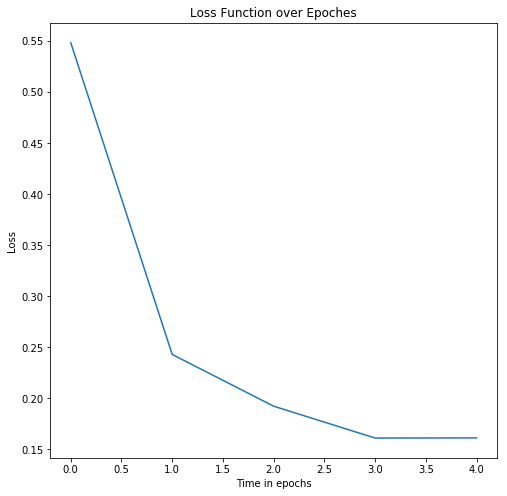

In [7]:
"""
Logistic Regression Classifier
"""

# Create the model and display the loss function
old_stdout = sys.stdout
sys.stdout = mystdout = io.StringIO()
logistic = SGDClassifier(random_state=345, loss = 'log', max_iter = 10000, tol = .001, verbose = 1)
clf = logistic.fit(x_train, y_train)
sys.stdout = old_stdout
loss_history = mystdout.getvalue()
loss_list = []
for line in loss_history.split('\n'):
    if(len(line.split("loss: ")) == 1):
        continue
    loss_list.append(float(line.split("loss: ")[-1]))
plt.figure(figsize = (8,8))
plt.plot(np.arange(len(loss_list)), loss_list)
plt.title('Loss Function over Epoches')
plt.xlabel("Time in epochs")
plt.ylabel("Loss")
plt.show()

In [8]:
"""
Predict values 
"""

# Construct confusion matrix
y_pred = clf.predict(x_test)
mat = confusion_matrix(y_test, y_pred)

# Compute accuracy, precision, recall
acc = (mat[0][0] + mat[1][1])/np.sum(mat)
prec = mat[1][1]/(mat[1][1]+mat[1][0])
rec = mat[1][1]/(mat[1][1]+mat[0][1])
print('Accuracy = ', acc)
print('Precision = ', prec)
print('Recall = ', rec)
# Alot of false negatives

# Get the coefficients
coef = clf.coef_[0]
coef_pairs = np.stack((np.array(list(train)[:-2]), coef), axis = -1)
print('Coefficients = ', coef_pairs, sep = '\n')

Accuracy =  0.46296296296296297
Precision =  0.0
Recall =  0.0
Coefficients = 
[['shortest_path' '-26.193970147600382']
 ['common_neighbors' '1.716357594267849']
 ['pref_attach' '-1.7099004142556533']
 ['neighbor_sum' '-2.150880084386224']
 ['sorensen' '-1.375255672421482']
 ['cosine_sim' '-1.6712198334539883']
 ['hub_prom' '-0.9181238797444822']
 ['hub_depr' '-3.952526446243291']
 ['resource_all' '2.2866943726260334']
 ['local_cluster_sum' '1.7855006366563138']
 ['local_cluster_prod' '-0.2594959912392392']
 ['local_path001' '1.841854179832106']
 ['local_path01' '2.835106050503924']
 ['local_path1' '7.0809586253758035']]


In [9]:
mat

array([[25,  1],
       [28,  0]], dtype=int64)

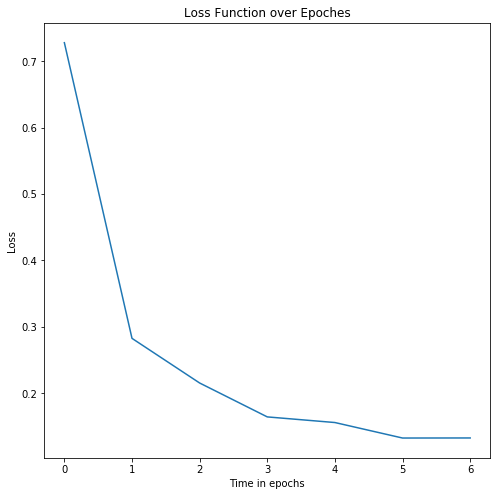

In [10]:
"""
SVM Classifier
"""

# Create the model and display the loss function
old_stdout = sys.stdout
sys.stdout = mystdout = io.StringIO()
svm = SGDClassifier(random_state=345, loss = 'hinge', max_iter = 10000, tol = .001, verbose = 1)
clf = svm.fit(x_train, y_train)
sys.stdout = old_stdout
loss_history = mystdout.getvalue()
loss_list = []
for line in loss_history.split('\n'):
    if(len(line.split("loss: ")) == 1):
        continue
    loss_list.append(float(line.split("loss: ")[-1]))
plt.figure(figsize = (8,8))
plt.plot(np.arange(len(loss_list)), loss_list)
plt.title('Loss Function over Epoches')
plt.xlabel("Time in epochs")
plt.ylabel("Loss")
plt.show()

In [11]:
"""
Predict values
"""

# Construct confusion matrix
y_pred = clf.predict(x_test)
mat = confusion_matrix(y_test, y_pred)

# Compute accuracy, precision, recall
acc = (mat[0][0] + mat[1][1])/np.sum(mat)
prec = mat[1][1]/(mat[1][1]+mat[1][0])
rec = mat[1][1]/(mat[1][1]+mat[0][1])
print('Accuracy = ', acc)
print('Precision = ', prec)
print('Recall = ', rec)
# Alot of false negatives

# Get the coefficients
coef = clf.coef_[0]
coef_pairs = np.stack((np.array(list(train)[:-2]), coef), axis = -1)
print('Coefficients = ', coef_pairs, sep = '\n')

Accuracy =  0.46296296296296297
Precision =  0.0
Recall =  0.0
Coefficients = 
[['shortest_path' '-20.917400971753096']
 ['common_neighbors' '1.152927612616319']
 ['pref_attach' '-1.6686782916345761']
 ['neighbor_sum' '-2.8715774699325785']
 ['sorensen' '-0.6660773757369348']
 ['cosine_sim' '-1.100202351231661']
 ['hub_prom' '-0.5334571034681348']
 ['hub_depr' '-3.3042810553953528']
 ['resource_all' '1.4866775345926984']
 ['local_cluster_sum' '1.4272729348160427']
 ['local_cluster_prod' '-0.5962495724829606']
 ['local_path001' '1.254544561562088']
 ['local_path01' '2.058799308243425']
 ['local_path1' '5.496746104900522']]


In [12]:
mat

array([[25,  1],
       [28,  0]], dtype=int64)

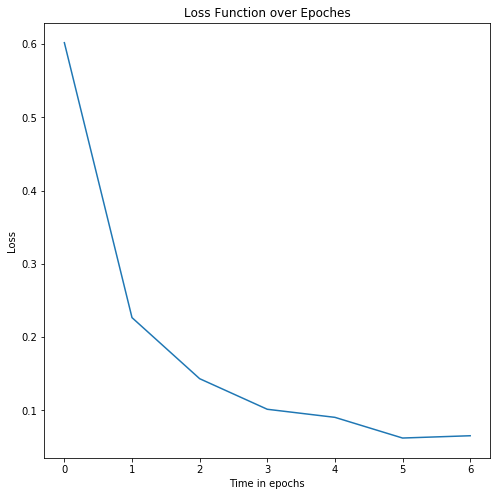

In [13]:
"""
Perceptron Classifier
"""

# Create the model and display the loss function
old_stdout = sys.stdout
sys.stdout = mystdout = io.StringIO()
svm = SGDClassifier(random_state=345, loss = 'perceptron', max_iter = 30, tol = .001, verbose = 1)
clf = svm.fit(x_train, y_train)
sys.stdout = old_stdout
loss_history = mystdout.getvalue()
loss_list = []
for line in loss_history.split('\n'):
    if(len(line.split("loss: ")) == 1):
        continue
    loss_list.append(float(line.split("loss: ")[-1]))
plt.figure(figsize = (8,8))
plt.plot(np.arange(len(loss_list)), loss_list)
plt.title('Loss Function over Epoches')
plt.xlabel("Time in epochs")
plt.ylabel("Loss")
plt.show()

In [14]:
"""
Predict values
"""

# Construct confusion matrix
y_pred = clf.predict(x_test)
mat = confusion_matrix(y_test, y_pred)

# Compute accuracy, precision, recall
acc = (mat[0][0] + mat[1][1])/np.sum(mat)
prec = mat[1][1]/(mat[1][1]+mat[1][0])
rec = mat[1][1]/(mat[1][1]+mat[0][1])
print('Accuracy = ', acc)
print('Precision = ', prec)
print('Recall = ', rec)
# Alot of false negatives

# Get the coefficients
coef = clf.coef_[0]
coef_pairs = np.stack((np.array(list(train)[:-2]), coef), axis = -1)
print('Coefficients = ', coef_pairs, sep = '\n')

Accuracy =  0.46296296296296297
Precision =  0.0
Recall =  0.0
Coefficients = 
[['shortest_path' '-12.846907683438925']
 ['common_neighbors' '1.3176315572757908']
 ['pref_attach' '-1.5341194966167937']
 ['neighbor_sum' '-1.5969121590896889']
 ['sorensen' '-0.15902888573088714']
 ['cosine_sim' '-0.6833224368379258']
 ['hub_prom' '-0.38070575160959824']
 ['hub_depr' '-2.9800143427851786']
 ['resource_all' '1.1067921452364584']
 ['local_cluster_sum' '1.3658956253990033']
 ['local_cluster_prod' '-0.5189814991272691']
 ['local_path001' '1.3983123509111282']
 ['local_path01' '2.036866370889274']
 ['local_path1' '4.766492470747681']]


In [15]:
mat

array([[25,  1],
       [28,  0]], dtype=int64)

In [16]:
"""
Random Forest Classifier
"""

# Create the model and display the loss function
forest = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=345, verbose = 0)
clf = forest.fit(x_train, y_train)

In [17]:
"""
Predict values
"""

# Construct confusion matrix
y_pred = clf.predict(x_test)
mat = confusion_matrix(y_test, y_pred)

# Compute accuracy, precision, recall
acc = (mat[0][0] + mat[1][1])/np.sum(mat)
prec = mat[1][1]/(mat[1][1]+mat[1][0])
rec = mat[1][1]/(mat[1][1]+mat[0][1])
print('Accuracy = ', acc)
print('Precision = ', prec)
print('Recall = ', rec)

# Get variable importance
imp = clf.feature_importances_
ind = np.argsort(imp)
coef_pairs = np.stack((np.array(list(train)[:-2])[ind], imp[ind]), axis = -1)
print('Importance = ', coef_pairs, sep = '\n')

Accuracy =  0.46296296296296297
Precision =  0.0
Recall =  0.0
Importance = 
[['neighbor_sum' '0.004030981961045292']
 ['pref_attach' '0.005599916630099776']
 ['local_cluster_sum' '0.006973083770504987']
 ['local_cluster_prod' '0.006985217679286875']
 ['sorensen' '0.01027437092253838']
 ['hub_depr' '0.012772327336515218']
 ['hub_prom' '0.021652203435589858']
 ['cosine_sim' '0.032382048164672536']
 ['resource_all' '0.04047150003021207']
 ['common_neighbors' '0.054774829943327503']
 ['local_path01' '0.08292159899496902']
 ['local_path001' '0.0985384099418167']
 ['local_path1' '0.15374724106907156']
 ['shortest_path' '0.46887627012035']]


In [18]:
mat

array([[25,  1],
       [28,  0]], dtype=int64)

In [19]:
"""
Adaboost Classifier
"""

# Create the model and display the loss function
adaboy = AdaBoostClassifier(random_state=345)
clf = adaboy.fit(x_train, y_train)

In [20]:
"""
Predict values
"""

# Construct confusion matrix
y_pred = clf.predict(x_test)
mat = confusion_matrix(y_test, y_pred)

# Compute accuracy, precision, recall
acc = (mat[0][0] + mat[1][1])/np.sum(mat)
prec = mat[1][1]/(mat[1][1]+mat[1][0])
rec = mat[1][1]/(mat[1][1]+mat[0][1])
print('Accuracy = ', acc)
print('Precision = ', prec)
print('Recall = ', rec)

# Get variable importance
ind = np.argsort(imp)
imp = clf.feature_importances_
coef_pairs = np.stack((np.array(list(train)[:-2])[ind], imp[ind]), axis = -1)
print('Importance = ', coef_pairs, sep = '\n')

Accuracy =  0.46296296296296297
Precision =  0.0
Recall =  0.0
Importance = 
[['neighbor_sum' '0.14']
 ['pref_attach' '0.06']
 ['local_cluster_sum' '0.1']
 ['local_cluster_prod' '0.12']
 ['sorensen' '0.08']
 ['hub_depr' '0.1']
 ['hub_prom' '0.08']
 ['cosine_sim' '0.08']
 ['resource_all' '0.06']
 ['common_neighbors' '0.0']
 ['local_path01' '0.1']
 ['local_path001' '0.02']
 ['local_path1' '0.04']
 ['shortest_path' '0.02']]


In [21]:
mat

array([[25,  1],
       [28,  0]], dtype=int64)

In [22]:
"""
Naive Bayes Classifier
"""

# Create the model and display the loss function
naive = BernoulliNB()
clf = naive.fit(x_train, y_train)

In [23]:
"""
Predict values
"""

# Construct confusion matrix
y_pred = clf.predict(x_test)
mat = confusion_matrix(y_test, y_pred)

# Compute accuracy, precision, recall
acc = (mat[0][0] + mat[1][1])/np.sum(mat)
prec = mat[1][1]/(mat[1][1]+mat[1][0])
rec = mat[1][1]/(mat[1][1]+mat[0][1])
print('Accuracy = ', acc)
print('Precision = ', prec)
print('Recall = ', rec)

Accuracy =  0.6481481481481481
Precision =  0.8214285714285714
Recall =  0.6216216216216216


In [24]:
mat

array([[12, 14],
       [ 5, 23]], dtype=int64)